In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.models import efficientnet_b3
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall, BinaryF1Score
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.transforms_interface import DualTransform
from tqdm import tqdm
import copy
from IPython.display import Image
from tabulate import tabulate

cv2.setNumThreads(0)

In [2]:
class SEBlock(nn.Module):
    """
    Позволяют сети "взвешивать" каналы признаков, 
    уделяя больше внимания самым важным из них.
    """
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels//reduction, 1),
            nn.SiLU(),
            nn.Conv2d(channels//reduction, channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)

In [3]:
class UBlock(nn.Module):
    """Базовый сверточный блок"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()
    
    def forward(self, x):
        out = self.act(self.bn(self.conv(x)))
        return out


class UBlockSet(nn.Module):
    """2 базовых блока + skip connection"""
    def __init__(self, in_channels, out_channels, residual=True):
        super().__init__()
        self.block1 = UBlock(in_channels, out_channels)
        self.block2 = UBlock(out_channels, out_channels)
        self.residual = residual
        self.se = SEBlock(out_channels)
        self.dropout = nn.Dropout2d(0.03)
        
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
    
    def forward(self, x):
        out = self.block2(self.block1(x))
        if self.residual:
            if self.downsample:
                x = self.downsample(x)
            out += x
        out = self.se(out)
        out = self.dropout(out)
        return out

In [4]:
class UpsampleBlock(nn.Module):
    """Блок для увеличения размера карт признаков"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = UBlock(in_channels, out_channels)
        
    def forward(self, x):
        size = (x.shape[-2] * 2, x.shape[-1] * 2)
        out = F.interpolate(x, size=size, mode="bicubic", align_corners=False)
        out = self.block(out)
        return out

In [5]:
class ChannelReductionBlock(nn.Module):
    """Блок для изменения числа каналов"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()
    
    def forward(self, x):
        if isinstance(x, list):
            x = torch.cat(x, dim=1)
        out = self.act(self.bn(self.conv(x)))
        return out

### Interpolate

Используется для изменения размеров тензора путем применения интерполяции. Например,  в случае билинейной интерполяции вычисляется значение каждого нового пикселя как взвешенное среднее из четырех ближайших к нему пикселей в исходном тензоре.

Например, есть 4 пикселя (`A`, `B`, `C`, `D`) в исходной сетке. Стоит задача найти значение пикселя `P`, который находится где-то между ними.

Сначала выполняется линейная интерполяция по горизонтали, чтобы найти значения в точках `R1` (между `A` и `B`) и `R2` (между `C` и `D`).

Затем выполняется линейная интерполяция по вертикали между точками `R1` и `R2` по формуле `(1 - dy) * R1 + dy * R2`, чтобы найти итоговое значение `P`. `dy ∈ [0, 1]` $-$ удаленность от точки `R1`. `(1 - dy) ∈ [0, 1]` $-$ удаленность от точки `R2`.

In [6]:
class Interpolate(nn.Module):
    """Модуль для интерполяции"""
    def __init__(self, size, mode="bicubic", align_corners=False, antialias=False):
        super().__init__()
        self.size = size
        self.mode = mode
        self.align_corners = align_corners
        self.antialias = antialias

    def forward(self, x):
        result = F.interpolate(x, 
                               size=self.size, 
                               mode=self.mode, 
                               align_corners=self.align_corners, 
                               antialias=self.antialias)
        return result

### FullScaleConnection

В классической `U-Net` декодер на каждом уровне получает информацию только с одного, симметричного ему, уровня энкодера благодаря `skip connection`. В этой реализации `U-Net` подобной сети декодер на каждом уровне получает информацию с каждого уровня энкодера.

Как он работает:

- Он берет выходы со `всех` уровней энкодера (от самого глубокого до самого поверхностного). $\newline$

- Уменьшает их канальность с помощью свёрток 1x1 (self.reduces), чтобы снизить вычислительную нагрузку. $\newline$

- Затем он приводит все эти карты признаков к одному целевому размеру, который нужен на текущем этапе декодера. Глубокие карты признаков он увеличивает (upsample), а поверхностные — уменьшает (downsample). $\newline$

- Конкатенирует все эти подготовленные карты признаков.

In [7]:
class FullScaleConnection(nn.Module):
    def __init__(self, connection_indx, out_channels, encoder_channels, reduced_channels=24, img_size=512):
        super().__init__()
        output_size = 512 // 2**(5 - connection_indx)
        self.upsample_count = connection_indx
        self.downsample_count = 4 - connection_indx
        self.reduces = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(ch, reduced_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduced_channels),
                nn.SiLU()
            ) for ch in encoder_channels
        ])
        self.upsample = Interpolate(size=output_size, antialias=False)
        self.downsample = Interpolate(size=output_size, antialias=True)
        self.channel_reduction = ChannelReductionBlock(reduced_channels * 5, out_channels)
        

    def forward(self, x):
        result = [] 
        for out, reduce in zip(x, self.reduces):
            result.append(reduce(out))
        for i in range(self.upsample_count):
            result[i] = self.upsample(result[i])
        for i in range(self.downsample_count):
            result[4-i] = self.downsample(result[4-i])
        out = self.channel_reduction(result)
        return out

### SPPF

Помогает модели "видеть" контекст на разных уровнях детализации одновременно.
    
Принцип работы:

- Входной тензор последовательно проходит через несколько `MaxPool2d`. $\newline$ 

- Результаты после каждого пулинга, а также исходный тензор конкатенируются по оси каналов. $\newline$
  
- Получается тензор, который содержит информацию о признаках, "увиденных" через "окна" разного размера. $\newline$

- Свёртка 1x1 смешивает всю эту мультимасштабную информацию. $\newline$

- Используется остаточная связь, чтобы добавить обогащенную информацию к исходному тензору. $\newline$

In [8]:
class SPPF(nn.Module):
    def __init__(self, channels, k=5):
        super().__init__()
        c = max(16, channels // 2)
        self.cv1 = UBlock(channels, c, kernel_size=1, padding=0)
        self.cv2 = UBlock(c * 4, channels, kernel_size=1, padding=0)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
        
    def forward(self, x):
        out = self.cv1(x)
        tensors_to_concat = [out]
        
        for _ in range(3):
            out = self.m(out)
            tensors_to_concat.append(out)
        
        concat_tensor = torch.cat(tensors_to_concat, dim=1)
        out = self.cv2(concat_tensor)
        return x + out

## Архитектура классической UNet

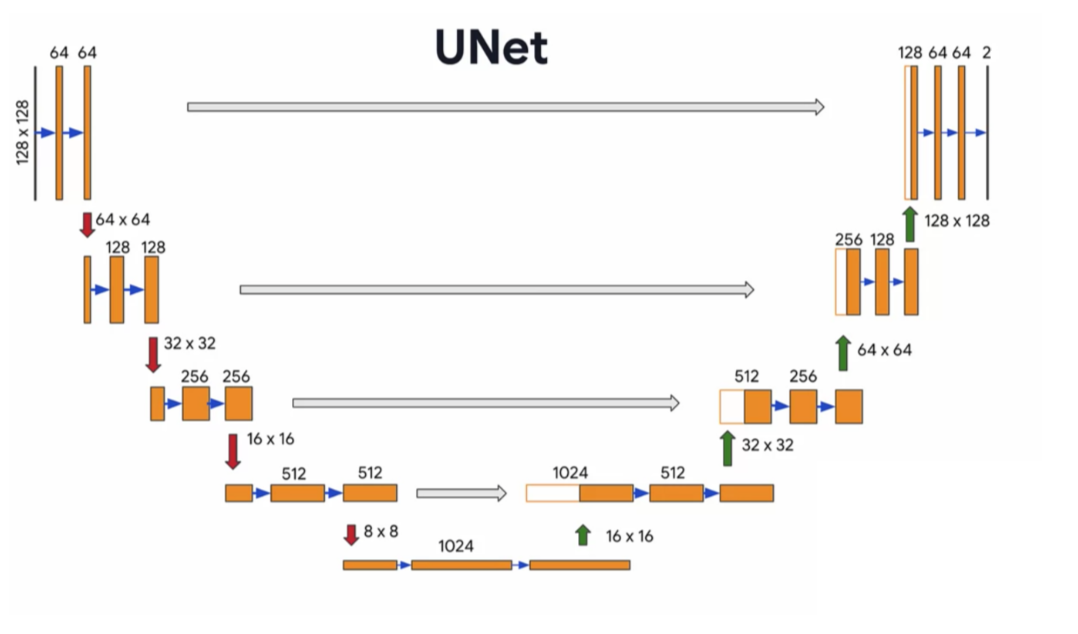

In [7]:
Image("UNet.png", width="80%")

# Собственная реализация UNet подобной модели

In [9]:
class ResUNet(nn.Module):
    def __init__(self, classes=2, img_size=512):
        super().__init__()
        self.channels = [32, 24, 32, 48, 136, 384, 512]  
        backbone = efficientnet_b3(weights='DEFAULT').features
        self.block0 = nn.Sequential(
            backbone[0],
            backbone[1]
        )
        self.block1 = backbone[2]
        self.block2 = backbone[3]
        self.block3 = nn.Sequential(
            backbone[4],
            backbone[5]
        )
        self.block4 = nn.Sequential(
            backbone[6],
            backbone[7]
        )
        self.sppf = SPPF(self.channels[-2])
        self.final_block = nn.Sequential(
            nn.Conv2d(self.channels[-2], self.channels[-1], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.channels[-1]),
            nn.SiLU(),
            nn.Dropout2d(0.05),
            UBlockSet(self.channels[-1], self.channels[-1]),
            UpsampleBlock(self.channels[-1], self.channels[-2])
        )

        encoder_channels = self.channels[-2:0:-1]
        for i in range(len(self.channels)-2, 0, -1):
            full_scale_block = FullScaleConnection(5 - i, self.channels[i], encoder_channels)
            skip_block = UBlockSet(self.channels[i], self.channels[i])
            channel_reduction = ChannelReductionBlock(self.channels[i] * 2, self.channels[i])
            block = UBlockSet(self.channels[i], self.channels[i-1])
            upsample = UpsampleBlock(self.channels[i-1], self.channels[i-1])
            indx = len(self.channels)-2
            setattr(self, f"full_scale_block{indx-i}", full_scale_block)
            setattr(self, f"skip_block{indx-i}", skip_block)
            setattr(self, f"channel_reduction{indx-i}", channel_reduction)
            setattr(self, f"upblock{indx-i}", block)
            setattr(self, f"upsample{indx-i}", upsample)

        self.fconv = nn.Sequential(
            UBlockSet(self.channels[0], self.channels[0]),
            UBlock(self.channels[0], self.channels[0]),
            nn.Conv2d(self.channels[0], classes, kernel_size=1, padding=0)
        )

    def forward(self, x):
        # энкодер
        out1 = self.block0(x)
        out2 = self.block1(out1)
        out3 = self.block2(out2)
        out4 = self.block3(out3)
        out5 = self.block4(out4)
        out = self.sppf(out5)
        out = self.final_block(out)
        encoder_outs = [out5, out4, out3, out2, out1]
        
        # декодер
        full_scale_out = self.full_scale_block0(encoder_outs)
        skip_out = self.skip_block0(full_scale_out)
        out = self.channel_reduction0([out, skip_out])
        out = self.upblock0(out)
        out = self.upsample0(out)

        full_scale_out = self.full_scale_block1(encoder_outs)
        skip_out = self.skip_block1(full_scale_out)
        out = self.channel_reduction1([out, skip_out])
        out = self.upblock1(out)
        out = self.upsample1(out)

        full_scale_out = self.full_scale_block2(encoder_outs)
        skip_out = self.skip_block2(full_scale_out)
        out = self.channel_reduction2([out, skip_out])
        out = self.upblock2(out)
        out = self.upsample2(out)

        full_scale_out = self.full_scale_block3(encoder_outs)
        skip_out = self.skip_block3(full_scale_out)
        out = self.channel_reduction3([out, skip_out])
        out = self.upblock3(out)
        out = self.upsample3(out)

        full_scale_out = self.full_scale_block4(encoder_outs)
        skip_out = self.skip_block4(full_scale_out)
        out = self.channel_reduction4([out, skip_out])
        out = self.upblock4(out)
        out = self.upsample4(out)

        # классификация пикселей
        out = self.fconv(out)
        return out

# Скорость инференса модели на CPU и GPU

In [16]:
%%time
with torch.no_grad():
    print(ResUNet()(torch.rand(1, 3, 512, 512)).shape)

torch.Size([1, 2, 512, 512])
CPU times: user 2.15 s, sys: 422 ms, total: 2.58 s
Wall time: 1.44 s


In [17]:
%%time
with torch.no_grad():
    print(ResUNet().to("cuda")(torch.rand(1, 3, 512, 512).to("cuda")).shape)

torch.Size([1, 2, 512, 512])
CPU times: user 451 ms, sys: 9.16 ms, total: 460 ms
Wall time: 429 ms


In [18]:
class ProductDataset(Dataset):
    def __init__(self, url, transforms=None):
        self.url = url
        self.transforms = transforms
        self.images = sorted(os.listdir(os.path.join(url, "images")))
        self.masks_url = os.path.join(url, "masks")

    def __getitem__(self, indx):
        image_name = self.images[indx]
        name, _ = os.path.splitext(image_name)
        mask_name = f"{name}.png"
        
        image_path = os.path.join(self.url, "images", image_name)
        mask_path = os.path.join(self.url, "masks", mask_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = (mask > 0).long()
        
        return image, mask 

    def __len__(self):
        return len(self.images)

### CrossEntropyLoss + DiceLoss

Комбинация `CrossEntropyLoss` и `DiceLoss` с использованием карты весов. Пикселям, находящимся на границе объекта, присваивается гораздо больший вес при вычислении ошибки. Это заставляет модель уделять максимум внимания именно четкости краев.

In [19]:
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=1.0, dice_weight=1.0, eps=1e-6):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.eps = eps
        self.ce = nn.CrossEntropyLoss(reduction='none')
        self.softmax = nn.Softmax(dim=1)

    def binary_dice_loss(self, probs, target, weights):
        probs_flat = probs.view(probs.size(0), -1) 
        target_flat = target.view(target.size(0), -1)
        weights_flat = weights.view(weights.size(0), -1)
        inter = (weights_flat * probs_flat * target_flat).sum(dim=1) 
        denom = (weights_flat * probs_flat).sum(dim=1) + (weights_flat * target_flat).sum(dim=1) 
        dice = (2*inter + self.eps) / (denom + self.eps) 
        return 1.0 - dice.mean() 

    def forward(self, logits, targets, weights):
        ce = self.ce(logits, targets) 
        ce = (weights * ce).mean()
        probs_fg = self.softmax(logits)[:,1,:,:] 
        dice = self.binary_dice_loss(probs_fg, targets.float(), weights) 
        return self.ce_weight * ce + self.dice_weight * dice

### [CopyPaste](https://albumentations.ai/docs/4-advanced-guides/creating-custom-transforms/)

Этот класс реализует аугментацию данных, которая вырезает объект из одного изображения и вставляет на случайный фон.

Класс наследуется от `DualTransform` из библиотеки `albumentations`, что означает, что он умеет применять согласованные преобразования к паре "изображение + маска".

**В методе `__init__`:**

- Первым делом вызывается инициализатор родительского класса `super().__init__(p=p)`. Параметр `p` (например, `p=0.5`) устанавливает вероятность срабатывания этой аугментации. $\newline$

- Далее в цикле открывается каждое изображение фона, каждый фон сохраняется в список `self.bg_list`. Все изображения загружаются в оперативную память один раз при создании объекта, чтобы во время обучения не тратить время на чтение файлов с диска.

**В методе `get_params_dependent_on_data`:**

Вызывается пайплайном albumentations перед применением трансформации. Его задача — вычислить все необходимые параметры и подготовить данные.

**В методе `apply`:**

Получает на вход исходное изображение `img` и параметры, вычисленные на предыдущем шаге (из словаря `{"bg": ...}`, название параметра должно совпадать с ключом словаря).

**В методе `apply_to_mask`:**

Отвечает за преобразование маски. Получает на вход исходную маску `mask` и параметры из словаря (в данном случае для этого метода нет никаких других параметров, так как в словаре нет подходящего ключа к названию параметра).

In [20]:
class CopyPaste(DualTransform):
    def __init__(self, bg_path, size=(512, 512), p=0.5):
        super().__init__(p=p)
        self.bg_path = bg_path
        self.size = size
        self.bg_names = os.listdir(self.bg_path)
        self.bg_list = []
        for bg_name in self.bg_names:
            path = os.path.join(self.bg_path, bg_name)
            bg = cv2.imread(path)
            bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
            self.bg_list.append(bg)

    def get_params_dependent_on_data(self, params, data):
        bg = self.py_random.choice(self.bg_list)
        bg_resized = cv2.resize(bg, self.size, interpolation=cv2.INTER_CUBIC)
        bg_resized[data["mask"] > 0] = data["image"][data["mask"] > 0]

        return {"bg": bg_resized}
         
    def apply(self, img, bg, **params):
        return bg

    def apply_to_mask(self, mask, **params):
        return mask

### Набор аугментации 

In [21]:
def get_train_augmentations(bg_path, copy_paste_proba=0.5):
    train_transforms = A.Compose(
        [
            A.SmallestMaxSize(max_size=600, 
                              interpolation=cv2.INTER_LANCZOS4, 
                              mask_interpolation=cv2.INTER_NEAREST, 
                              p=1),
            A.CropNonEmptyMaskIfExists(height=512, width=512, p=0.25),
            A.LongestMaxSize(max_size=512, 
                             interpolation=cv2.INTER_LANCZOS4,
                             mask_interpolation=cv2.INTER_NEAREST,
                             p=1),
            A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, p=1),
            A.HorizontalFlip(p=0.5),
            A.Affine(scale=(0.8, 1.2), translate_percent=(-0.2, 0.2), rotate=(-45, 45), 
                shear=(-5, 5), balanced_scale=True, border_mode=0, 
                interpolation=cv2.INTER_LANCZOS4, mask_interpolation=cv2.INTER_NEAREST, 
                keep_ratio=True, p=0.85),
            A.OneOf([
                A.Perspective(scale=(0.01, 0.05), keep_size=True, fit_output=True, 
                    border_mode=0, p=1),
                A.ElasticTransform(alpha=50, sigma=10, same_dxdy=False, p=1),   
                A.GridDistortion(num_steps=5, distort_limit=(-0.15, 0.15),
                    normalized=True, p=1),
                A.ThinPlateSpline(scale_range=(0.03, 0.05),
                    num_control_points=3, p=1),
            ], p=0.2),
            CopyPaste(bg_path=bg_path, p=copy_paste_proba),
            A.OneOf([
                A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", 
                    noise_params={"mean_range": [0, 0], "std_range": [0.01, 0.02]}, p=1),
                A.ISONoise(color_shift=(0.01, 0.05), intensity = (0.1, 0.2), p=1)
            ], p=0.25),
            A.OneOf([
                A.Emboss(alpha=(0.2, 0.5), strength=(0.3, 0.5), p=1),
                A.CLAHE(clip_limit=(1, 2), p=1),
                A.Sharpen(alpha=(0, 0.25), p=1),
            ], p=0.3),
            A.OneOf([
                A.OneOf([
                    A.Blur(blur_limit=(3, 3), p=1),
                    A.MotionBlur(blur_limit=(3, 5), allow_shifted=True, p=1),
                    A.MedianBlur(blur_limit=(3, 5), p=1)
                ], p=1),
                A.OneOf([
                    A.ImageCompression(compression_type='jpeg', 
                        quality_range=(40, 70), p=1),
                    A.Downscale(scale_range=(0.5, 0.7), 
                        interpolation_pair={'upscale': 0, 'downscale': 0}, p=1)
                ], p=1),
            ], p=0.05),
            A.OneOf([
                A.ChannelShuffle(p=1),
                A.RGBShift(r_shift_limit=(-30, 30), 
                           g_shift_limit=(-30, 30), 
                           b_shift_limit=(-30, 30),
                           p=1),
                A.PlanckianJitter(mode='blackbody', temperature_limit=(6000, 10000), 
                    sampling_method='uniform', p=1),
                A.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), 
                    saturation=(0.9, 1.1), hue=(-0.1, 0.1), p=1)
            ], p=0.9),
            A.Normalize(),
            A.ToTensorV2()
        ]
    )
    return train_transforms

In [22]:
bg_path = "/kaggle/input/bg-dataset/bg_dataset"

In [23]:
pretrain_transforms = get_train_augmentations(bg_path, copy_paste_proba=0.4)
train_transforms = get_train_augmentations(bg_path, copy_paste_proba=0.025)

In [24]:
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=512, interpolation=cv2.INTER_LANCZOS4,
                         mask_interpolation=cv2.INTER_NEAREST, p=1),
        A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, p=1),
        A.Normalize(),
        A.ToTensorV2()
    ]
)

In [25]:
PRETRAINING_DATASET_PATH = "/kaggle/input/roboflow-shoes-dataset/dataset_out"
TRAIN_DATASET_PATH = "/kaggle/input/final-unet-dataset/unet_dataset_final/train"
VALID_DATASET_PATH = "/kaggle/input/final-unet-dataset/unet_dataset_final/valid"

In [26]:
pretrain_dataset = ProductDataset(PRETRAINING_DATASET_PATH, transforms=pretrain_transforms)
pretrain_dataloader = DataLoader(pretrain_dataset, 
                                 batch_size=8, 
                                 shuffle=True, 
                                 drop_last=True, 
                                 num_workers=2, 
                                 pin_memory=True,
                                 persistent_workers=True)

train_dataset = ProductDataset(TRAIN_DATASET_PATH, transforms=train_transforms)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=8, 
                              shuffle=True, 
                              drop_last=True, 
                              num_workers=2, 
                              pin_memory=True, 
                              persistent_workers=True)

test_dataset = ProductDataset(VALID_DATASET_PATH, transforms=test_transforms)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=1, 
                             shuffle=False, 
                             drop_last=False, 
                             num_workers=2, 
                             pin_memory=True)

## Примеры изображений с примененными к ним аугментациями

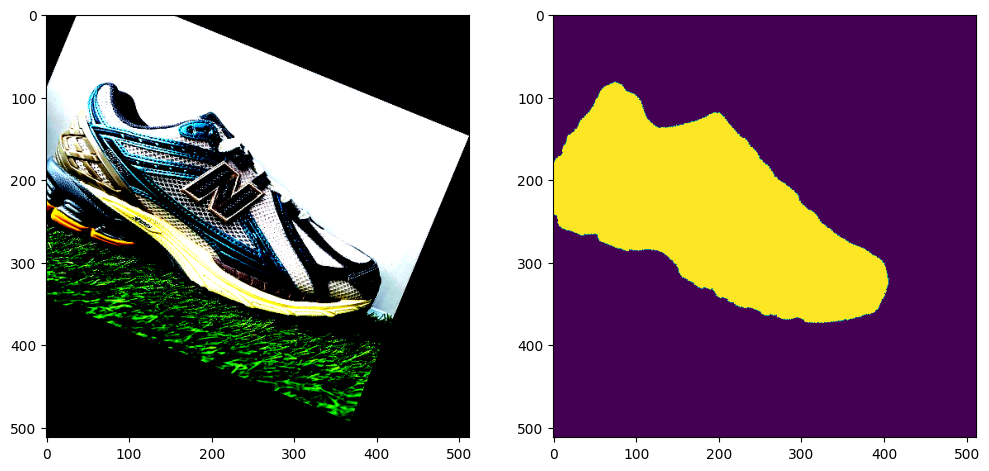

In [30]:
result = train_dataset[41]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(result[0].permute(1, 2, 0));

plt.subplot(1, 2, 2)
plt.imshow(result[1]);

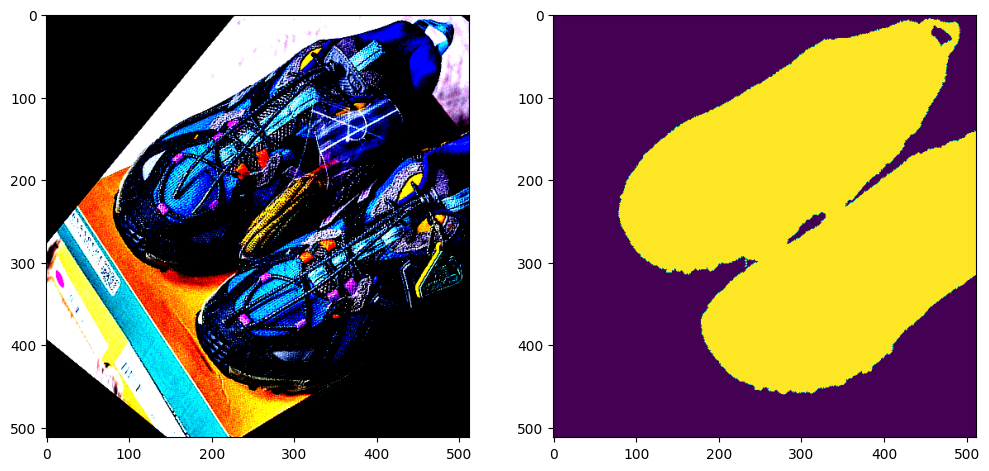

In [34]:
result = train_dataset[46]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(result[0].permute(1, 2, 0));

plt.subplot(1, 2, 2)
plt.imshow(result[1]);

### Функции, чтобы получить карту весов для функции потерь. Веса на границе объекта и фона выше.

In [35]:
def find_boundaries(mask, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, dtype=np.uint8)
    
    dilated = cv2.dilate(mask, kernel, iterations=1)
    eroded = cv2.erode(mask, kernel, iterations=1)
    
    boundary = dilated - eroded
    return boundary


def create_distance_weight_map(mask, w0=3, sigma=6.5):  
    boundaries = find_boundaries(mask.astype(np.uint8))
    boundaries_inv = 1 - boundaries
    distance_map = cv2.distanceTransform(boundaries_inv, cv2.DIST_L2, 5)
    distance_map = np.minimum(distance_map, 255).astype(np.float32)
    # w = 1.0 + w0 * exp(-d^2 / (2 * sigma^2))
    weight_map = 1.0 + w0 * np.exp(-1 * (distance_map**2) / (2 * sigma**2))
    
    return weight_map.astype(np.float32)

In [36]:
img, mask = train_dataset[0]
weight_map = create_distance_weight_map(mask.numpy())

In [37]:
weight_map.min(), weight_map.max()

(1.0, 4.0)

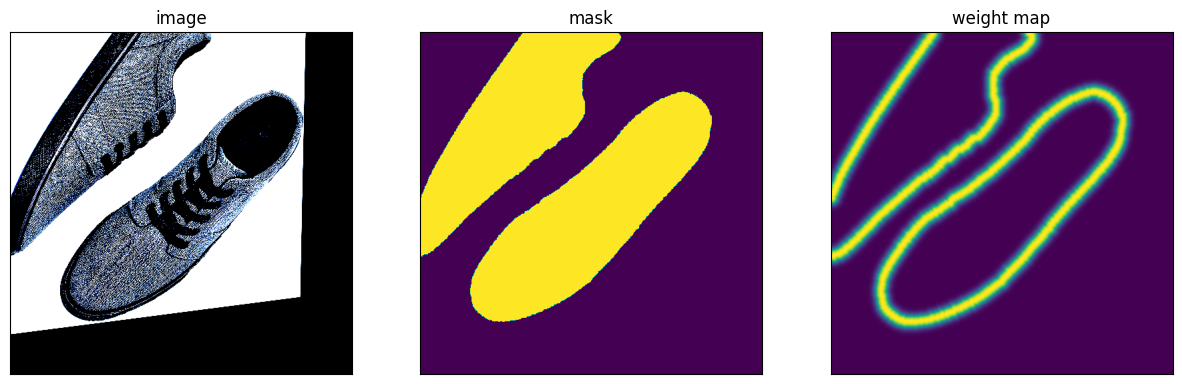

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0))
plt.xticks([]), plt.yticks([])
plt.title("image")
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.xticks([]), plt.yticks([])
plt.title("mask")
plt.subplot(1, 3, 3)
plt.imshow(weight_map)
plt.xticks([]), plt.yticks([])
plt.title("weight map");

In [39]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [40]:
device

device(type='cuda')

In [41]:
model = ResUNet(2).to(device)

### Функция, которая возвращает параметры модели для оптимизатора. Она позволяет настроить разные learning rate для энкодера и декодера, регуляризацию. Для bias регуляризация убрана.

In [42]:
def get_model_parameters(model, base_lr=1e-3, backbone_lr_ratio=0.5, weight_decay=5e-4):
    backbone_weights = []
    backbone_bias = []
    other_weights = []
    other_bias = []
    
    for name, param in model.named_parameters():
        if "block" == name[:5] and name[5].isdigit():
            if 'weight' in name:
                backbone_weights.append(param)
            else:
                backbone_bias.append(param)
        else:
            if 'weight' in name:
                other_weights.append(param)
            else:
                other_bias.append(param)

    backbone_lr = base_lr * backbone_lr_ratio
    parameters = []
    
    if backbone_weights:
        parameters.append({"params": backbone_weights, "weight_decay": weight_decay, "lr": backbone_lr})
    if backbone_bias:
        parameters.append({"params": backbone_bias, "weight_decay": 0, "lr": backbone_lr})
    if other_weights:
        parameters.append({"params": other_weights, "weight_decay": weight_decay, "lr": base_lr})
    if other_bias:
        parameters.append({"params": other_bias, "weight_decay": 0, "lr": base_lr})
    
    return parameters

### Функция для обучения модели и выбора лучшей модели на валидационной выборке

In [48]:
def trainer(model, criterion, optimizer, scheduler, metric, dataloader):
    best_metric = 0
    best_model = None
    trains = []
    evals = []
    
    for epoch in range(EPOCHS):
        running_loss = 0
        m = 0
        model.train()
        metric.reset()
        
        progress_bar = tqdm(dataloader,
                            leave=False,
                            unit="batch")
        
        for image, mask in progress_bar:
            image = image.to(device)
            mask = mask.to(device)
            weight_maps_np = [create_distance_weight_map(m.cpu().numpy()) for m in mask]
            weight_maps = torch.from_numpy(np.array(weight_maps_np)).to(device)
    
            optimizer.zero_grad()
            pred_mask = model(image)
            loss = criterion(pred_mask, mask, weight_maps)
            loss.backward()
            optimizer.step()
    
            value = loss.item()
            m += 1
            running_loss = 1/m * value + (1 - 1/m) * running_loss
    
            pred_probs = torch.softmax(pred_mask, dim=1)[:, 1]
            metric.update(pred_probs, mask.int())

            text = f"Epoch = {epoch}; Loss = {running_loss:.3f}; max IoU metric = {best_metric:.4f};"
            progress_bar.set_description(text)
    
        total_iou_train = metric.compute()
    
        model.eval()
        metric.reset()
        with torch.no_grad():  
            for image, mask in test_dataloader:
                image = image.to(device)
                mask = mask.to(device)
    
                pred_mask = model(image)
                pred_probs = torch.softmax(pred_mask, dim=1)[:, 1]
                metric.update(pred_probs, mask.int())
    
        total_iou = metric.compute()
    
        if total_iou > best_metric:
            best_metric = total_iou.item()
            best_model = copy.deepcopy(model.state_dict())
    
        scheduler.step()
        evals.append(total_iou.item())
        trains.append(total_iou_train.item())

    return best_metric, best_model, trains, evals

# <Обучение модели>

**Обучение происходит в 2 этапа:**

- **Этап 1.** Обучение на большом датасете с разметкой среднего качества. На этом этапе модель получает базовое "понимание" того, как выглядят объекты. $\newline$

- **Этап 2.** Fine-tuning модели на небольшом датасете с идеальной разметкой. Это позволяет как бы "отполировать" ее знания.

**Особенности обучения:**

- В качестве энкодера используется предобученная модель `efficientnet_b3`. Чтобы не "сломать" ее веса во время обучения на 1 этапе с использованием данных неидеального качества, для энкодера используется низкий `learning rate`. На 2 этапе обучения для энкодера `learning rate` повышается, чтобы энкодер мог адаптироваться к новым качественным данным. $\newline$

- На 1 этапе обучения `weight_decay` высокий, чтобы модель не переобучалась на некачественных данных, на 2 этапе `weight_decay` снижается, чтобы модель могла обучиться и найти закономерности в данных. 

In [49]:
EPOCHS = 35

In [50]:
criterion = CombinedLoss(ce_weight=1.0, dice_weight=1.0)
param_groups = get_model_parameters(model, base_lr=1e-3, backbone_lr_ratio=0.01, weight_decay=0.5)
optimizer = torch.optim.AdamW(param_groups)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=5e-5)
metric = BinaryJaccardIndex(threshold=0.5).to(device)

In [51]:
best_metric, best_model, trains, evals = trainer(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    metric, 
    pretrain_dataloader
)

In [52]:
best_metric

0.9213865995407104

In [53]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [55]:
EPOCHS = 150

In [56]:
criterion = CombinedLoss(ce_weight=1.0, dice_weight=1.0)
param_groups = get_model_parameters(model, backbone_lr_ratio=0.5, weight_decay=5e-4)
optimizer = torch.optim.AdamW(param_groups)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
metric = BinaryJaccardIndex(threshold=0.5).to(device)

In [57]:
best_metric, best_model_main, trains, evals = trainer(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    metric, 
    train_dataloader
)

## График метрики IoU на тренировочной и валидационной выборках

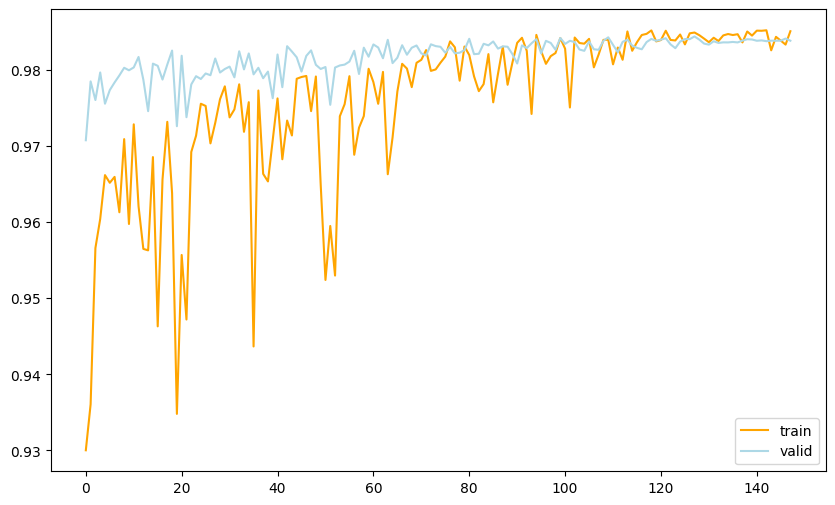

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(trains[2:], color='orange', label="train");
plt.plot(evals[2:], color='lightblue', label="valid");
plt.legend();

In [60]:
best_metric

0.9844414591789246

In [66]:
model.load_state_dict(best_model_main)

<All keys matched successfully>

In [44]:
torch.save(model.state_dict(), "best_model.pth")

In [113]:
best_state_dict = torch.load("best_model.pth", weights_only=True)
model.load_state_dict(best_state_dict)

<All keys matched successfully>

### Финальная оценка лучшей модели по метрикам `IoU`, `Precision`, `Recall` и `F1`

In [31]:
iou_metric = BinaryJaccardIndex(threshold=0.5).to(device)
precision_metric = BinaryPrecision(threshold=0.5).to(device)
recall_metric = BinaryRecall(threshold=0.5).to(device)
f1_metric = BinaryF1Score(threshold=0.5).to(device)

all_metrics = {
    "IoU": iou_metric,
    "Precision": precision_metric,
    "Recall": recall_metric,
    "F1": f1_metric
}

model.eval()
for metric in all_metrics.values():
    metric.reset()

with torch.no_grad():
    for image, mask in test_dataloader:
        image = image.to(device)
        mask = mask.to(device)
        pred_mask = model(image)
        pred_probs = torch.softmax(pred_mask, dim=1)[:, 1]

        for metric in all_metrics.values():
            metric.update(pred_probs, mask.int())

results = {name: round(metric.compute().item(), 4) for name, metric in all_metrics.items()}

In [47]:
headers = ["Metric", "Value"]
data = [[metric, f"{value:.4f}"] for metric, value in results.items()] 
print(tabulate(data, headers=headers, tablefmt="fancy_grid", numalign="decimal"))

╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ IoU       │  0.9847 │
├───────────┼─────────┤
│ Precision │  0.9925 │
├───────────┼─────────┤
│ Recall    │  0.992  │
├───────────┼─────────┤
│ F1        │  0.9923 │
╘═══════════╧═════════╛


In [119]:
show_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=512, p=1),
        A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, p=1),
        A.ToFloat(max_value=255),
        A.ToTensorV2()
    ]
)

## Визуализация работы модели

Что показано на визуализации:

- Изображение

- Предсказанная моделью маска

- Вырезанный объект (на изображении оставляются только те пиксели, для которых модель предсказала класс "объект")

In [120]:
images_path = "/kaggle/input/test-unet/test_unet"

In [148]:
def get_images_mask(image_name):
    image_path = os.path.join(images_path, image_name)
        
    test_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = test_transforms(image=test_image)["image"].unsqueeze(0).to(device)
        
    model.eval()
    with torch.no_grad():
        pred = model(image)[0]
        
    pred_mask = pred.cpu().argmax(0)
    test_image = show_transforms(image=test_image)["image"].permute(1, 2, 0)
    
    image_ = test_image.permute(2, 0, 1)
    new_mask = pred_mask.unsqueeze(0).repeat(3, 1, 1)
    new_image = image_ * new_mask
    new_image = new_image.permute(1, 2, 0)
    new_image[new_mask.permute(1, 2, 0) == 0] = 1

    return test_image, pred_mask, new_image

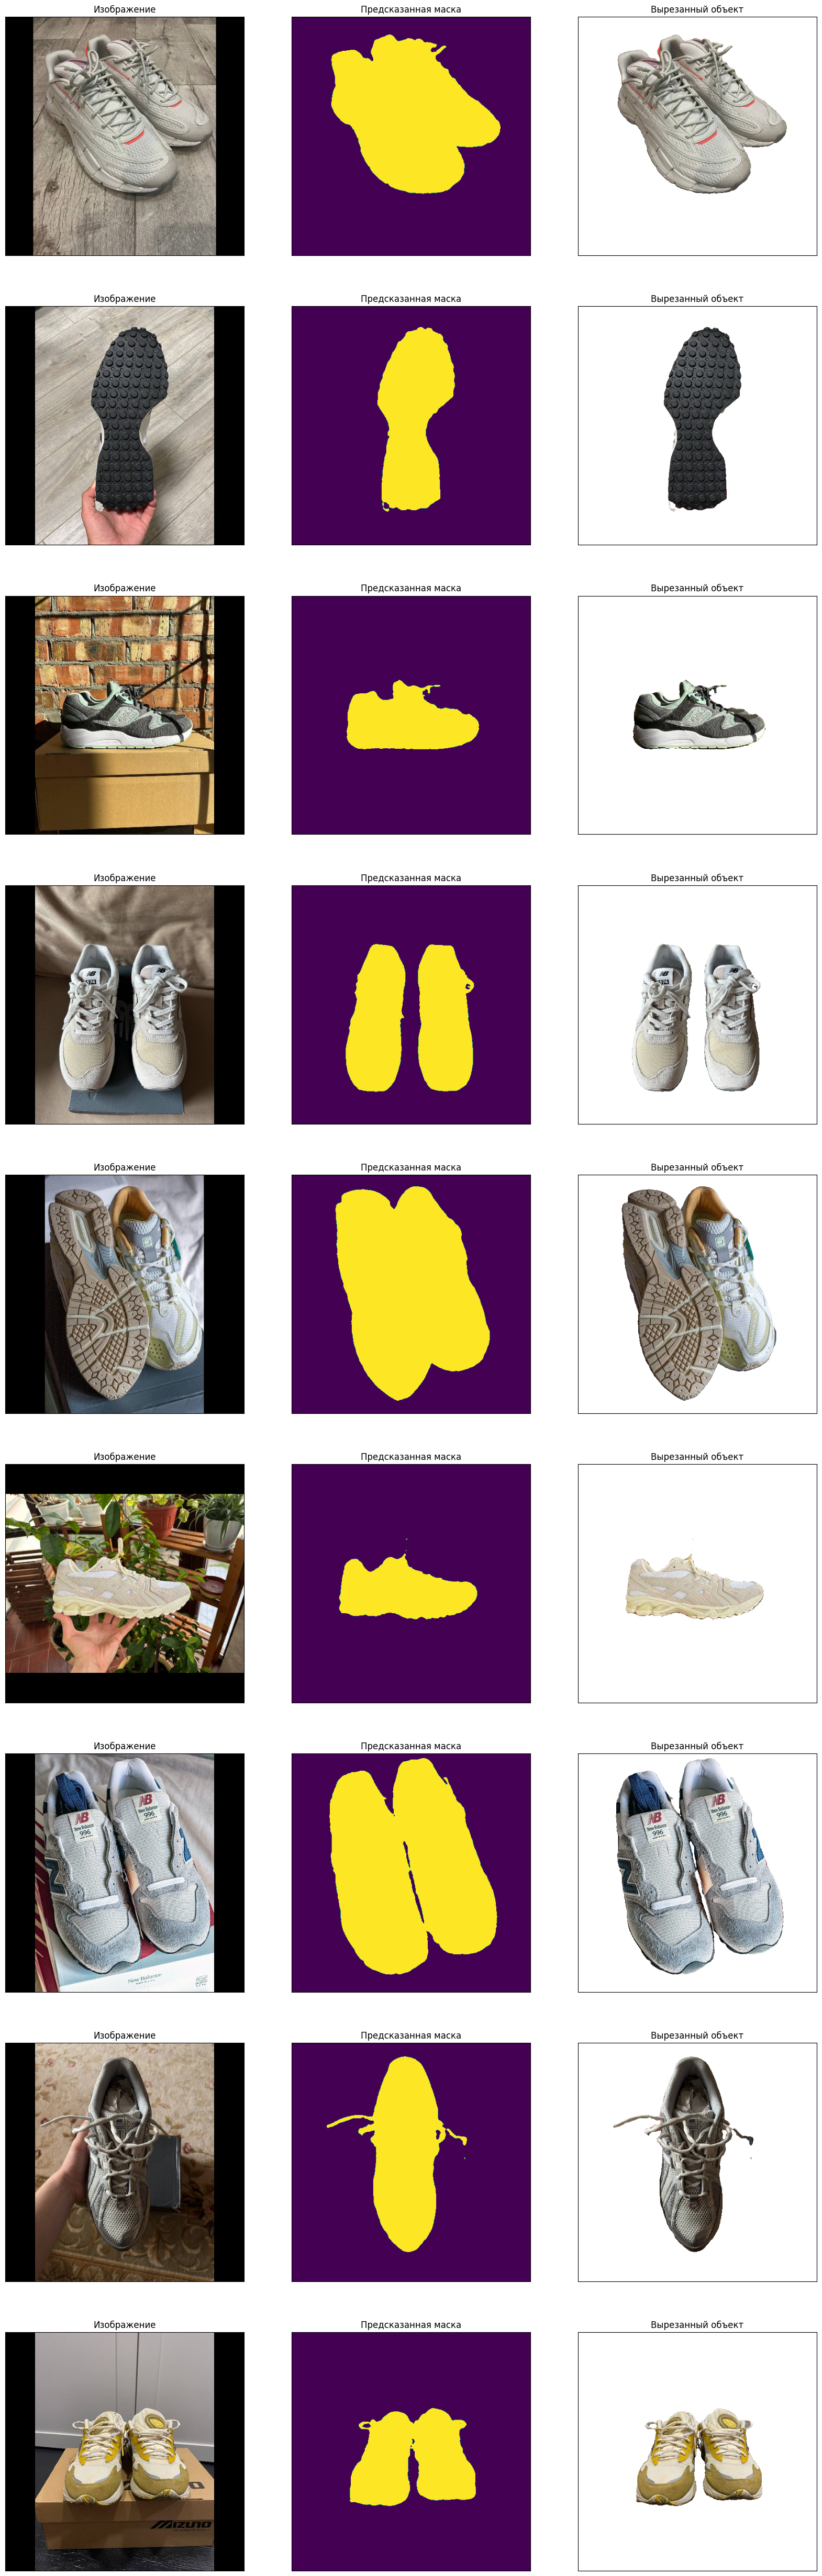

In [159]:
plt.figure(figsize=(20, 85))
images = os.listdir(images_path)
for i in range(len(images)):
    image_name = images[i]
    test_image, pred_mask, new_image = get_images_mask(image_name)
    
    plt.subplot(12, 3, i*3+1)
    plt.title("Изображение")
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_image)
    plt.subplot(12, 3, i*3+2)
    plt.title("Предсказанная маска")
    plt.xticks([]), plt.yticks([])
    plt.imshow(pred_mask)
    plt.subplot(12, 3, i*3+3)
    plt.title("Вырезанный объект")
    plt.xticks([]), plt.yticks([])
    plt.imshow(new_image);

# Практическое применение

**Например, можно автоматически вырезать объект обуви из изображения и его накладывать на более подходящий фон. Примеры ниже только как пример, не обязательно после смотрится лучше.**

In [271]:
def show_image(bg_name, bg_size, image, position=None):
    new_image = cv2.imread(os.path.join(bg_path, bg_name))
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = cv2.resize(new_image, bg_size) / 255
    
    previous_image, mask, image = get_images_mask(image)
    if position:
        new_mask = torch.zeros(bg_size).long()
        new_mask[position[0]:position[0]+512, position[1]:position[1]+512] = mask
        new_image[new_mask > 0] = image[mask > 0]
    else:
        new_image[mask > 0] = image[mask > 0]
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.xticks([]), plt.yticks([])
    plt.title("До")
    plt.imshow(previous_image);
    plt.subplot(1, 2, 2)
    plt.xticks([]), plt.yticks([])
    plt.title("После")
    plt.imshow(new_image);

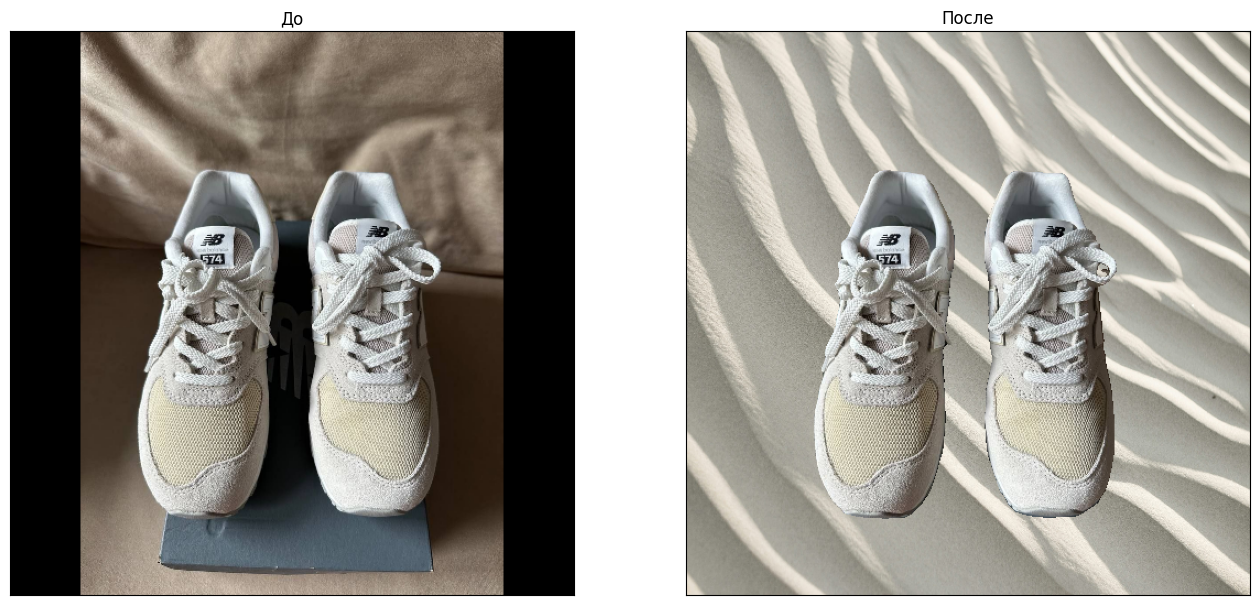

In [272]:
show_image("100.jpg", (512, 512), images[3])

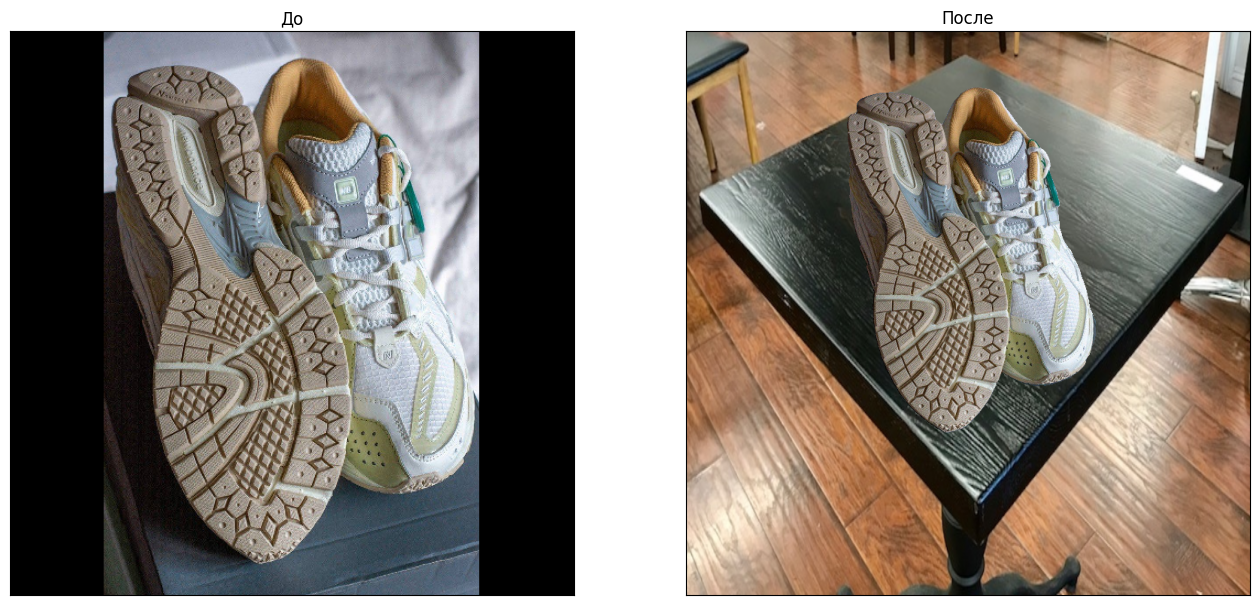

In [273]:
show_image("85.jpg", (750, 750), images[4], (50, 120))

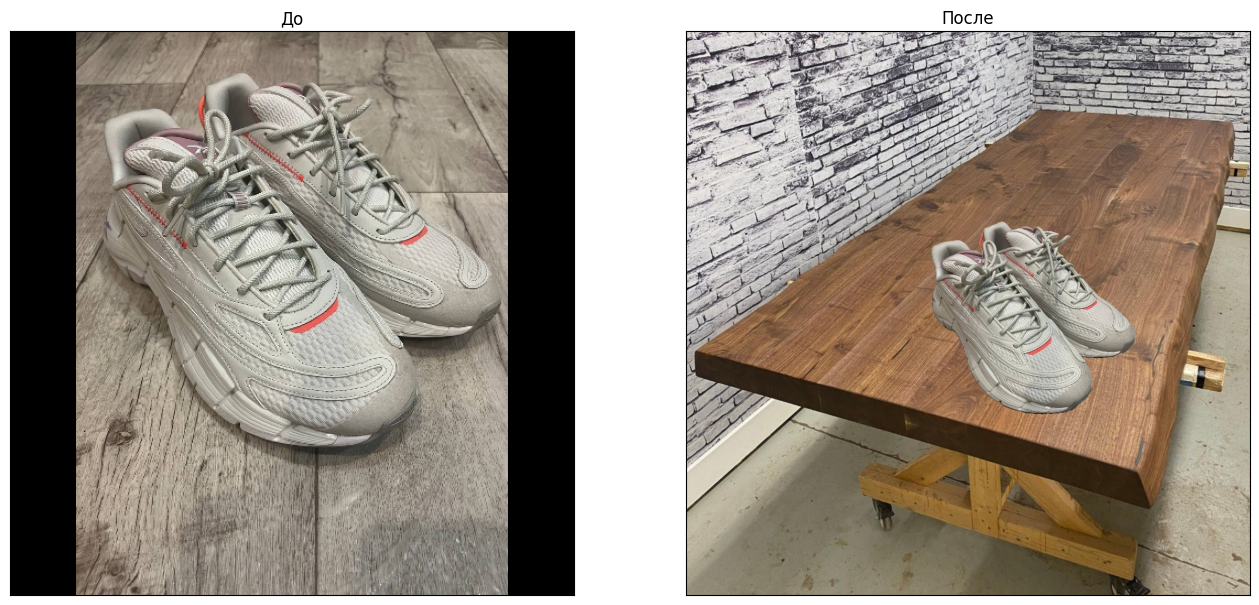

In [279]:
show_image("78.jpg", (1000, 1000), images[0], (300, 350))